In [27]:
from __future__ import print_function

import torch
import torch.optim as optim

from torch.utils.data.dataset import Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.backends.cudnn.bencmark = True
import torchvision
import torchvision.transforms as transforms

import os,sys,cv2,random,datetime,time,math
import argparse
import numpy as np

from net_s3fd import *
from s3fd import *
from bbox import *
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

In [28]:
class CelebDataset(Dataset):
    """Dataset wrapping images and target labels
    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['Image_Name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['Image_Name']
        self.y_train = self.mlb.fit_transform(tmp_df['Gender'].str.split()).astype(np.float32)
    def __getitem__(self, index):
        img = cv2.imread(self.img_path + self.X_train[index] + self.img_ext)
        img = cv2.resize(img, (256,256))
        img = img - np.array([104,117,123])
        img = img.transpose(2, 0, 1)
        
        #img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        #img = Variable(torch.from_numpy(img).float(),volatile=True)
        
        #if self.transform is not None:
        #    img = self.transform(img)
        
        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train.index)

In [29]:
transformations = transforms.Compose(
    [
     transforms.ToTensor()
     
     #transforms.Normalize(mean=[104,117,123])
     ])

In [30]:
train_data = "index.csv"
img_path = "data/Celeb_Small_Dataset/"
img_ext = ".jpg"
dset = CelebDataset(train_data,img_path,img_ext,transformations)
train_loader = DataLoader(dset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
tensor([ 1.,  0.])
torch.Size([2])
torch.Size([2])
tensor([ 1.,  0.])
(256, 256, 3)


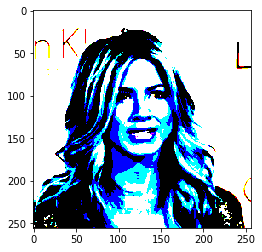

In [31]:
## bad data visualization, perhaps need to change from BGR to RGB
fig = plt.figure()
for i in range(len(dset)):
    sample = dset[0]
    print(i)
    print(sample[1])
    image = sample[0]
    tensor_result = sample[1]
    print(sample[1].size())
#     tensor_result = tensor_result.unsqueeze(0)
#     tensor_result = tensor_result.unsqueeze(2)
#     tensor_result = tensor_result.unsqueeze(3)
#     tensor_result = tensor_result.expand(23,2)
    print(tensor_result.size())
    print(tensor_result)
#     tensor_repeated = tensor_result.
    image_changed = image.permute(1,2,0)
    print(image_changed.numpy().shape)
#     print(image.transpose().shape)
#     image_changed = [image[1], image[2], image[0]]
    plt.imshow(image_changed)
    break

In [32]:
def save(model, optimizer, loss, filename):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.data[0]
        }
    torch.save(save_dict, filename)

In [33]:
# initialize the new model
num_classes = 2
myModel = s3fd(num_classes)

# load pre trained weights
loadedModel = torch.load('s3fd_convert.pth')
newModel = myModel.state_dict()

# compute intersection
pretrained_dict = {k: v for k, v in loadedModel.items() if k in newModel}

# update newModel dictionary
newModel.update(pretrained_dict)
#update the pytorch model
myModel.load_state_dict(newModel)

# freeze all layers
for param in myModel.parameters():
    param.requires_grad = False

myModel.fc_1.weight.requires_grad = True
myModel.fc_1.bias.requires_grad = True

In [34]:
use_cuda = True
print(myModel.eval())
for name, parameter in myModel.named_parameters():
    print(name)
    print(parameter.requires_grad)

s3fd(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512

In [37]:
def train_model(model, criterion, optimizer, num_classes, num_epochs = 100):
    losses = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        model.train()
        running_loss = 0.0

        for i,(img,label) in enumerate(train_loader):
            img = img.view((1,)+img.shape[1:])
            if use_cuda:
                data, target = Variable(img.cuda()), Variable(torch.Tensor(label).cuda())
            else:
                data, target = Variable(img), Variable(torch.Tensor(label))
            target = target.view(1, num_classes)

            optimizer.zero_grad()
            gender_classifications = model(data)
            loss = criterion(gender_classifications, target)
            running_loss+= loss.item()
            loss.backward()
#             for name, parameter in model.named_parameters():
#                 if parameter.grad is not None:
#                     print(name)
#                     print(parameter.grad)
            optimizer.step()
        print("Loss = ", running_loss)
        print("-" * 10)
        losses.append(running_loss)
    return losses
        

In [38]:
criterion = nn.BCELoss()
# turn off gradient update for old layers
# for param in myModel.parameters():
#     param.requires_grad = False
# myModel.conv3_3_norm_gender.weight.requires_grad = True
# myModel.conv3_3_norm_gender.bias.requires_grad = True

# myModel.fc_1 = nn.Linear(2304,num_classes)
# for parameter in myModel.parameters():
#     print(parameter.requires_grad)
optimizer = optim.SGD(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.0001, momentum=0.9)
optimizer2 = optim.SGD(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.001, momentum=0.9)
optimizer3 = optim.SGD(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.01, momentum=0.9)

if use_cuda:
    print("using cuda")
    myModel = myModel.cuda()
model_0001 = train_model(myModel, criterion, optimizer, num_classes, num_epochs=100)
model_001 = train_model(myModel, criterion, optimizer2, num_classes, num_epochs=100)
model_01 = train_model(myModel, criterion, optimizer3, num_classes, num_epochs=100)

using cuda
Epoch 1/100
Loss =  128.51454934477806
----------
Epoch 2/100
Loss =  129.85995699465275
----------
Epoch 3/100
Loss =  126.42474375665188
----------
Epoch 4/100
Loss =  125.72337248921394
----------
Epoch 5/100
Loss =  124.87221898138523
----------
Epoch 6/100
Loss =  128.29409576952457
----------
Epoch 7/100
Loss =  126.23607462644577
----------
Epoch 8/100
Loss =  131.12904205918312
----------
Epoch 9/100
Loss =  123.43876995146275
----------
Epoch 10/100
Loss =  129.3401596918702
----------
Epoch 11/100
Loss =  125.02821899950504
----------
Epoch 12/100
Loss =  129.1924626454711
----------
Epoch 13/100
Loss =  128.9174106195569
----------
Epoch 14/100
Loss =  126.23922093212605
----------
Epoch 15/100
Loss =  125.11551930382848
----------
Epoch 16/100
Loss =  126.57033047825098
----------
Epoch 17/100
Loss =  125.95798751711845
----------
Epoch 18/100
Loss =  124.98565695807338
----------
Epoch 19/100
Loss =  126.9237317070365
----------
Epoch 20/100
Loss =  127.13050310

Loss =  153.34858786629047
----------
Epoch 64/100
Loss =  274.6786534490593
----------
Epoch 65/100
Loss =  183.92653231541044
----------
Epoch 66/100
Loss =  165.26961351686623
----------
Epoch 67/100
Loss =  195.7816793481761
----------
Epoch 68/100
Loss =  242.5773162808764
----------
Epoch 69/100
Loss =  152.56804162473418
----------
Epoch 70/100
Loss =  172.7105991261924
----------
Epoch 71/100
Loss =  159.86490773578407
----------
Epoch 72/100
Loss =  180.21159140852978
----------
Epoch 73/100
Loss =  188.34322062718275
----------
Epoch 74/100
Loss =  163.93510079174303
----------
Epoch 75/100
Loss =  203.81542098184946
----------
Epoch 76/100
Loss =  177.005865589701
----------
Epoch 77/100
Loss =  218.48187055025755
----------
Epoch 78/100
Loss =  156.69128044939134
----------
Epoch 79/100
Loss =  128.62211294379085
----------
Epoch 80/100
Loss =  180.45763109921245
----------
Epoch 81/100
Loss =  192.11106833425583
----------
Epoch 82/100
Loss =  161.86934048587864
----------

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

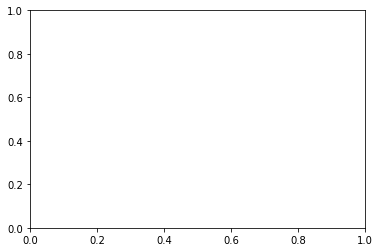

In [21]:
plt.plot(model_0001)

In [17]:
def transform(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256,256))
        img = img - np.array([104,117,123])
        img = img.transpose(2, 0, 1)
        
        img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        
        return Variable(img.cuda())
myModel = myModel.cuda()
testImage1 = transform('data/Test/TestCeleb_4/25-FaceId-0.jpg')
testImage2 = transform('data/Test/TestCeleb_4/26-FaceId-0.jpg')
testImage3 = transform('data/Test/TestCeleb_4/27-FaceId-0.jpg')
testImage4 = transform('data/Test/TestCeleb_10/25-FaceId-0.jpg')
testImage5 = transform('data/Test/TestCeleb_10/26-FaceId-0.jpg')
testImage6 = transform('data/Test/TestCeleb_8/26-FaceId-0.jpg')

output1 = myModel(testImage1)
output2 = myModel(testImage2)
output3 = myModel(testImage2)
output4 = myModel(testImage4)
output5 = myModel(testImage5)
output6 = myModel(testImage6)
print("testImage1 - ",output1)
print("testImage2 - ",output2)
print("testImage3 - ",output3)
print("testImage1 - ",output4)
print("testImage2 - ",output5)
print("testImage3 - ",output6)

testImage1 -  tensor([[ 0.2463,  0.7537]], device='cuda:0')
testImage2 -  tensor([[ 0.4145,  0.5855]], device='cuda:0')
testImage3 -  tensor([[ 0.4145,  0.5855]], device='cuda:0')
testImage1 -  tensor([[ 0.3995,  0.6005]], device='cuda:0')
testImage2 -  tensor([[ 0.3419,  0.6581]], device='cuda:0')
testImage3 -  tensor([[ 0.1945,  0.8055]], device='cuda:0')
